In [1]:
from PIL import Image
from tqdm.auto import tqdm
import cv2
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from timeit import default_timer as timer 
from sklearn.preprocessing import LabelEncoder

c:\Users\rainm\miniconda3\envs\pytorch2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Input
TRAIN_SUBSET_CSV_PATH = f"./output/df_train_subset.csv"

# Hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 40
NUM_WORKERS = 12
LR = 0.0005
TABULAR_COLUMNS  = ["age"]

In [3]:
DF_TRAIN_SUBSET = pd.read_csv(TRAIN_SUBSET_CSV_PATH)

In [4]:
DF_TRAIN_SUBSET["view"] = LabelEncoder().fit_transform(DF_TRAIN_SUBSET["view"])
DF_TRAIN_SUBSET["laterality"] = LabelEncoder().fit_transform(DF_TRAIN_SUBSET["laterality"])

In [5]:
DF_TRAIN_SUBSET.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,...,density,machine_id,difficult_negative_case,image_path,ID,Abnormality,Subtype,Path,Method_crop,processed_img_path
0,0,1.0,10130.0,3.888120e+08,0,4,71.0,1,1.0,1.0,...,B,49.0,False,./images_rsna/10130_388811999.png,NaN,NaN,NaN,NaN,NaN,./output/RSNA+INBREAST/10130_388811999.png
1,1,1.0,10130.0,6.134626e+08,0,1,71.0,1,1.0,1.0,...,B,49.0,False,./images_rsna/10130_613462606.png,NaN,NaN,NaN,NaN,NaN,./output/RSNA+INBREAST/10130_613462606.png
2,2,1.0,10130.0,1.360339e+09,0,1,71.0,1,1.0,1.0,...,B,49.0,False,./images_rsna/10130_1360338805.png,NaN,NaN,NaN,NaN,NaN,./output/RSNA+INBREAST/10130_1360338805.png
3,3,1.0,10130.0,1.672637e+09,0,4,71.0,1,1.0,1.0,...,B,49.0,False,./images_rsna/10130_1672636630.png,NaN,NaN,NaN,NaN,NaN,./output/RSNA+INBREAST/10130_1672636630.png
4,4,1.0,10226.0,4.616148e+08,0,4,71.0,1,1.0,1.0,...,C,49.0,False,./images_rsna/10226_461614796.png,NaN,NaN,NaN,NaN,NaN,./output/RSNA+INBREAST/10226_461614796.png


In [6]:
DF_TRAIN_SUBSET["age"] = DF_TRAIN_SUBSET["age"].fillna(DF_TRAIN_SUBSET["age"].mean())

In [7]:
class  MultiInputDataset(Dataset):
    
    def __init__(self, ds, tabular_columns, normalize, is_train=True):
        self.is_train = is_train
        self.ds = ds
        self.tabular_columns = tabular_columns

        self.transform = transforms.Compose([
                                            transforms.Resize((224, 224)),
                                            transforms.Grayscale(num_output_channels=3),
                                            transforms.ToTensor(),
                                            normalize
                                            ])
        
    def __len__(self):
        return len(self.ds)
    
    def __getitem__(self, idx):

        image_path = self.ds['processed_img_path'].iloc[idx]
        image = Image.open(image_path)
        
        image = self.transform(image)
        tabular_data = self.ds.iloc[idx, 0:]
        cancer = tabular_data["cancer"]
        tabular_data = np.array(self.ds.iloc[idx][TABULAR_COLUMNS].values, dtype=np.float32)

        return image, tabular_data, cancer

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225])
     
full_ds = MultiInputDataset(DF_TRAIN_SUBSET,
                            tabular_columns=TABULAR_COLUMNS,
                            normalize=normalize
                            )
train_length = round((full_ds.__len__()*80)/100)
test_length = full_ds.__len__() - train_length

train_ds, test_ds = torch.utils.data.random_split(dataset=full_ds, 
                                                lengths=[train_length, test_length], 
                                                generator=torch.Generator().manual_seed(42))

train_dataloader = DataLoader(train_ds, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True,
                            pin_memory=True)

test_dataloader = DataLoader(test_ds, 
                            batch_size=BATCH_SIZE,
                            shuffle=False,
                            pin_memory=True)

In [9]:
len(full_ds)

10504

In [10]:
item = train_ds.__getitem__(0)[0]
item

tensor([[[-0.0287, -0.9877, -1.1075,  ..., -2.0837, -2.0837, -2.0837],
         [ 0.1083, -0.1999, -0.5596,  ..., -2.0837, -2.0837, -2.0837],
         [ 0.8276,  1.0844,  1.2728,  ..., -2.0837, -2.0837, -2.0837],
         ...,
         [-0.6109, -0.3883, -0.3369,  ..., -2.0837, -2.0837, -2.0837],
         [-0.8507, -0.5424, -0.4226,  ..., -2.0837, -2.0837, -2.0837],
         [-1.1418, -1.0562, -1.1932,  ..., -2.0837, -2.0837, -2.0837]],

        [[ 0.1001, -0.8803, -1.0028,  ..., -2.0007, -2.0007, -2.0007],
         [ 0.2402, -0.0749, -0.4426,  ..., -2.0007, -2.0007, -2.0007],
         [ 0.9755,  1.2381,  1.4307,  ..., -2.0007, -2.0007, -2.0007],
         ...,
         [-0.4951, -0.2675, -0.2150,  ..., -2.0007, -2.0007, -2.0007],
         [-0.7402, -0.4251, -0.3025,  ..., -2.0007, -2.0007, -2.0007],
         [-1.0378, -0.9503, -1.0903,  ..., -2.0007, -2.0007, -2.0007]],

        [[ 0.3219, -0.6541, -0.7761,  ..., -1.7696, -1.7696, -1.7696],
         [ 0.4614,  0.1476, -0.2184,  ..., -1

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
""" weights = models.ResNet50_Weights.DEFAULT
model = models.resnet50(weights=weights) """

""" weights = models.EfficientNet_B4_Weights.DEFAULT
model = models.efficientnet_b4(weights=weights) """

weights = models.DenseNet121_Weights.DEFAULT
model = models.densenet121(weights=weights)

In [13]:
# freeze the base layers
for param in model.parameters():
    param.requires_grad = False

In [14]:
DROPOUT_PROB = 0.1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Densenet
IN_FEATURES = model.classifier.in_features
model.classifier = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2))

# Resnet
""" IN_FEATURES = model.fc.in_features
model.fc = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2)) """

# Efficientnet
""" IN_FEATURES = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
            nn.Dropout(p=DROPOUT_PROB, inplace=True),
            nn.Linear(in_features=IN_FEATURES, out_features=2)) """

' IN_FEATURES = model.classifier[1].in_features\nmodel.classifier[1] = nn.Sequential(\n            nn.Dropout(p=DROPOUT_PROB, inplace=True),\n            nn.Linear(in_features=IN_FEATURES, out_features=2)) '

In [15]:
class MultiInputClassifier(nn.Module):
    def __init__(self, model, use_tabular=False, output_neurons=16,  tabular_columns=len(TABULAR_COLUMNS)):
        super().__init__()
        self.use_tabular = use_tabular
        self.tabular_columns = tabular_columns
        self.output_neurons = output_neurons      
        self.pretrained = model

        self.tabular = nn.Sequential(nn.Linear(self.tabular_columns, self.output_neurons),
                                    nn.ReLU(),
                                    nn.Linear(self.output_neurons, self.output_neurons*3),
                                    nn.ReLU(),
                                    nn.Linear(self.output_neurons*3, self.output_neurons*3*3),
                                    nn.ReLU()
                                    )

        if self.use_tabular:
            self.img_plus_tab_classifier = nn.Linear(self.output_neurons*3*3+2, 2)
        else:
            self.img_classifier = nn.Linear(2, 2)

    def forward(self, img, tab):
        img = self.pretrained(img)
        tab = self.tabular(tab)

        if self.use_tabular:
            x = torch.cat((img, tab), dim=1)
            #x = nn.ReLU(x)
            x = self.img_plus_tab_classifier(x)       
        else:
            x = img
            x = self.img_classifier(x)
        return x

In [16]:
model_new = MultiInputClassifier(model, use_tabular=False)
#model_new

In [17]:
import engine

TEST_NAME = ""
loss_fn = nn.CrossEntropyLoss() # multi-class classification
optimizer = torch.optim.Adam(model_new.parameters(), lr=LR)

torch.manual_seed(42)
torch.cuda.manual_seed(42)

start_time = timer()
model_new = model_new.to(device)
# Setup training and save the results
results = engine.train(model=model_new,
                train_dataloader=train_dataloader,
                test_dataloader=test_dataloader,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epochs=NUM_EPOCHS,
                device=device,
                log_txt_saver=True,
                save_model = False,
                test_name = TEST_NAME
                )

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [01:01<19:32, 61.69s/it]

Epoch: 1 | train_loss: 0.5272 | train_acc: 0.7561 | test_loss: 0.4265 | test_acc: 0.8252


 10%|█         | 2/20 [01:51<16:19, 54.43s/it]

Epoch: 2 | train_loss: 0.4130 | train_acc: 0.8291 | test_loss: 0.4030 | test_acc: 0.8421


 15%|█▌        | 3/20 [02:37<14:23, 50.79s/it]

Epoch: 3 | train_loss: 0.4008 | train_acc: 0.8366 | test_loss: 0.3941 | test_acc: 0.8454


 20%|██        | 4/20 [03:20<12:46, 47.88s/it]

Epoch: 4 | train_loss: 0.3955 | train_acc: 0.8350 | test_loss: 0.4097 | test_acc: 0.8487


 25%|██▌       | 5/20 [04:04<11:33, 46.24s/it]

Epoch: 5 | train_loss: 0.3868 | train_acc: 0.8382 | test_loss: 0.3918 | test_acc: 0.8520


 30%|███       | 6/20 [04:47<10:34, 45.29s/it]

Epoch: 6 | train_loss: 0.3855 | train_acc: 0.8421 | test_loss: 0.3791 | test_acc: 0.8398


 35%|███▌      | 7/20 [05:31<09:42, 44.79s/it]

Epoch: 7 | train_loss: 0.3822 | train_acc: 0.8460 | test_loss: 0.3739 | test_acc: 0.8440


 40%|████      | 8/20 [06:14<08:51, 44.31s/it]

Epoch: 8 | train_loss: 0.3817 | train_acc: 0.8463 | test_loss: 0.3789 | test_acc: 0.8520


 45%|████▌     | 9/20 [06:58<08:04, 44.06s/it]

Epoch: 9 | train_loss: 0.3753 | train_acc: 0.8506 | test_loss: 0.3844 | test_acc: 0.8558


 50%|█████     | 10/20 [07:41<07:18, 43.89s/it]

Epoch: 10 | train_loss: 0.3784 | train_acc: 0.8474 | test_loss: 0.3730 | test_acc: 0.8534


 55%|█████▌    | 11/20 [08:24<06:33, 43.67s/it]

Epoch: 11 | train_loss: 0.3718 | train_acc: 0.8475 | test_loss: 0.3720 | test_acc: 0.8553


 60%|██████    | 12/20 [09:08<05:48, 43.60s/it]

Epoch: 12 | train_loss: 0.3766 | train_acc: 0.8496 | test_loss: 0.3707 | test_acc: 0.8501


 65%|██████▌   | 13/20 [09:51<05:04, 43.54s/it]

Epoch: 13 | train_loss: 0.3726 | train_acc: 0.8458 | test_loss: 0.3668 | test_acc: 0.8435


 70%|███████   | 14/20 [10:35<04:21, 43.55s/it]

Epoch: 14 | train_loss: 0.3704 | train_acc: 0.8490 | test_loss: 0.3727 | test_acc: 0.8558


 75%|███████▌  | 15/20 [11:20<03:40, 44.01s/it]

Epoch: 15 | train_loss: 0.3778 | train_acc: 0.8451 | test_loss: 0.3655 | test_acc: 0.8482


 80%|████████  | 16/20 [12:03<02:54, 43.71s/it]

Epoch: 16 | train_loss: 0.3711 | train_acc: 0.8517 | test_loss: 0.3669 | test_acc: 0.8534


 85%|████████▌ | 17/20 [12:45<02:10, 43.35s/it]

Epoch: 17 | train_loss: 0.3653 | train_acc: 0.8541 | test_loss: 0.3710 | test_acc: 0.8563


 90%|█████████ | 18/20 [13:28<01:26, 43.15s/it]

Epoch: 18 | train_loss: 0.3706 | train_acc: 0.8501 | test_loss: 0.3663 | test_acc: 0.8482


 95%|█████████▌| 19/20 [14:10<00:42, 42.91s/it]

Epoch: 19 | train_loss: 0.3743 | train_acc: 0.8477 | test_loss: 0.3651 | test_acc: 0.8464


100%|██████████| 20/20 [14:53<00:00, 44.67s/it]

Epoch: 20 | train_loss: 0.3612 | train_acc: 0.8562 | test_loss: 0.3688 | test_acc: 0.8586
[INFO] Total training time: 893.676 seconds


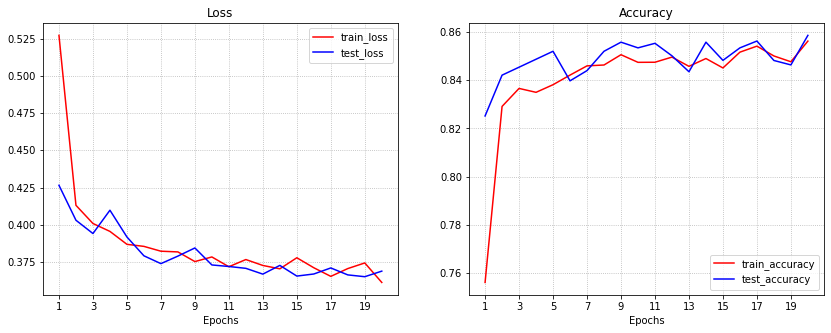

In [18]:
from util.util_plot import *

# Plot the loss curves of our model
plot_loss_accuracy_grid2_v2(results)

In [19]:
test_preds = []

model_new.to(device)
model_new.eval()

start_time_testset = timer()

with torch.inference_mode():
  for data, tab, target in tqdm(test_dataloader):
    data, tab, target = data.to(device), tab.to(device), target.to(device)
    
    test_logits = model_new(data, tab)
    pred_probs = torch.softmax(test_logits, dim=1)  # Convert the pred logits to pred probs
    pred_labels = torch.argmax(pred_probs, dim=1)  # Convert the pred probs into pred labels

    test_preds.append(pred_labels) 

end_time_testset = timer()
print(f"Total testing time: {end_time_testset-start_time_testset:.3f} (s).")

test_preds = torch.cat(test_preds).cpu()
test_truth = torch.cat([target for data, tab, target in test_dataloader])

100%|██████████| 53/53 [00:07<00:00,  7.54it/s]


Total testing time: 7.028 (s).


Main Parameters of model:Batch size: 40 
Epochs: 20 
Learning Rate: 0.0005 
Dropout Prob: 0.1 
Training time: 7.028


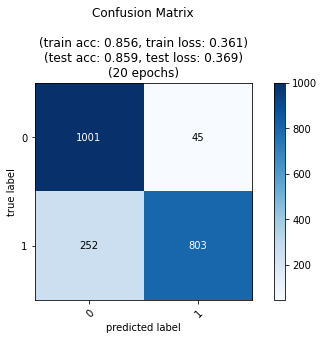

In [20]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

conf_matrix_multiclass = ConfusionMatrix(task="multiclass", num_classes=2)
conf_matrix_tensor = conf_matrix_multiclass(preds=test_preds, target=test_truth)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_matrix_tensor.numpy(), 
    class_names=["0", "1"],
    figsize=(8, 4),
    colorbar=True,
    # cmap = 'magma_r'
)

last_train_acc = round(results['train_acc'][NUM_EPOCHS-1],3)
last_train_loss = round(results['train_loss'][NUM_EPOCHS-1],3)
last_test_acc = round(results['test_acc'][NUM_EPOCHS-1],3)
last_test_loss = round(results['test_loss'][NUM_EPOCHS-1],3)

ax.set_title(f"Confusion Matrix"
    +f"\n\n"+
    f"(train acc: {last_train_acc}, train loss: {last_train_loss})\n" +
    f"(test acc: {last_test_acc}, test loss: {last_test_loss})\n" +
    f"({NUM_EPOCHS} epochs)"
    )

print(f"Main Parameters of model:"+ 
      f"Batch size: {BATCH_SIZE} \n"+
      f"Epochs: {NUM_EPOCHS} \n"+
      f"Learning Rate: {LR} \n"+
      f"Dropout Prob: {DROPOUT_PROB} \n"+
      f"Training time: {end_time_testset-start_time_testset:.3f}"
      )

In [21]:
from sklearn.metrics import classification_report
print(classification_report(test_truth, test_preds))

              precision    recall  f1-score   support

           0       0.80      0.96      0.87      1046
           1       0.95      0.76      0.84      1055

    accuracy                           0.86      2101
   macro avg       0.87      0.86      0.86      2101
weighted avg       0.87      0.86      0.86      2101



[0.         0.04302103 1.        ]
[0.         0.76113744 1.        ]
[2 1 0]


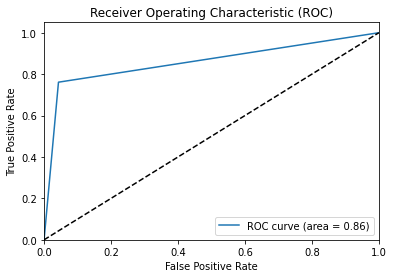

In [22]:
from sklearn.metrics import roc_curve, auc

# Plot an ROC. pred - the predictions, y - the expected output.
def plot_roc(pred,y,dropIntOpt):
    fpr, tpr, thresholds = roc_curve(y, pred,drop_intermediate=dropIntOpt)
    roc_auc = auc(fpr, tpr)
    print(fpr)
    print(tpr)
    print(thresholds)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

plot_roc(test_preds,test_truth,False)

## Single Image Prediction

In [23]:
simple_transform2 = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)), 
    transforms.ToTensor(), # between 0 & 1 
    transforms.Normalize(mean=[0.485, 0.456, 0.406], # mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225]) # standard deviation of [0.229, 0.224, 0.225] (across each colour channel)
])

In [24]:
def get_laterality(img):
    img2 = img.convert('L')
    img_array = np.asarray(img2)
    img_array_T = np.transpose(img_array)
    if np.sum(img_array_T[0]) < np.sum(img_array_T[-1]):
        laterality = "R"
    else:
        laterality = "L"
    return laterality

In [25]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)

    out = cv2.bitwise_and(img_array, mask)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped = out[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]

    return cropped, mask


In [26]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [27]:
def truncation_normalization(img, mask):
    mask = cv2.resize(mask, np.array(img).T.shape, interpolation = cv2.INTER_AREA)
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [28]:
def process_image(image_path):
    img = Image.open(image_path)

    cropped, mask = crop(img)
    normalized = truncation_normalization(cropped, mask)
    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    processed_img = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    processed_img_resized = cv2.resize(processed_img, (224, 224), interpolation = cv2.INTER_AREA)

    
    laterality = get_laterality(img) 
    if laterality == 'R':
        return cv2.flip(processed_img_resized, 1)
    else:
        return processed_img_resized

In [29]:
def pred_single_img(image_path, model, transform, class_names, device=device):
  
  prep_image = process_image(image_path)
  to_pil_img = transforms.ToPILImage()
  prep_image = to_pil_img(prep_image)
  transformed_image = transform(prep_image)
  print(transformed_image.shape)

  model.eval()
  with torch.inference_mode():
    pred_logit = model(transformed_image.unsqueeze(0).to(device), torch.zeros(1).to(device))
    pred_prob = torch.softmax(pred_logit, dim=1)
    pred_label = torch.argmax(pred_prob, dim=1)
    pred_class = class_names[pred_label.cpu()]
  
  pred_prob_squeezed = pred_prob.unsqueeze(0).max().cpu().item()
  # plot image and pred
  plt.imshow(prep_image,'gray')
  plt.title(f"Pred: {pred_class} \n"+ 
            f"Probability: {pred_prob_squeezed:.3f} \n"+
            f"(h: {prep_image.height}, w: {prep_image.width})",
            fontsize=18)
            
  plt.axis(False); 

  print(prep_image)
  print("img width:", prep_image.width, 
          "\nimg height:", prep_image.height)
  

torch.Size([3, 224, 224])
<PIL.Image.Image image mode=RGB size=224x224 at 0x24A44C24E20>
img width: 224 
img height: 224


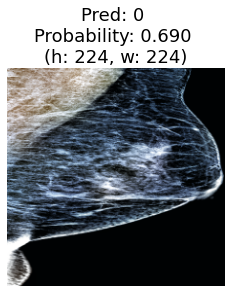

In [30]:
single_img_path_name = "./images_rsna/6018_640156723.png"

pred_single_img(image_path=single_img_path_name,
              model=model_new,
              transform=simple_transform2,
              class_names=["0", "1"])